In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

# extra_train = JigsawData(MAX_WORD_NUM)
# extra_train.load_data("data/train.csv")
# extra_train_df = extra_train.preprocess()

because hes a moron and a bigot its not any more complicated than that
how about we stop protecting idiots and let nature add some bleach to the gene pool we can always submit their names for the darwin awards
if people  were  smart they would  boycott this  inept  airline  but   they  are  not  smart  so   rogue  businesses  like  this  one   still thrive   taking the idiots  for  a ride
trump claimed that russia will never invade the ukraine when russia already has  how stupid can people be
as long as your willing to pay a lot more for products you buy then fine but you better not be going to costco and walmart to buy stuff because its cheaper if so we get to call you a hypocritical wanker
only an idiot would use and believe anything this this republican propaganda machine publishes wwwrealclearpoliticscom
thanks a lot douchebag youre the reason the portland buttfuckers are getting pushed out and moving down south to the wilsonville area and beyond because of you all the stupid fucki

In [21]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
print((train_df.sentence.sum()))
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=True)
tokenizer.fit_on_texts(train_df.sentence)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts
###


because hes a moron and a bigot its not any more complicated than thathow about we stop protecting idiots and let nature add some bleach to the gene pool we can always submit their names for the darwin awardsif people  were  smart they would  boycott this  inept  airline  but   they  are  not  smart  so   rogue  businesses  like  this  one   still thrive   taking the idiots  for  a ridetrump claimed that russia will never invade the ukraine when russia already has  how stupid can people beas long as your willing to pay a lot more for products you buy then fine but you better not be going to costco and walmart to buy stuff because its cheaper if so we get to call you a hypocritical wankeronly an idiot would use and believe anything this this republican propaganda machine publishes wwwrealclearpoliticscomthanks a lot douchebag youre the reason the portland buttfuckers are getting pushed out and moving down south to the wilsonville area and beyond because of you all the stupid fucking ass

In [20]:
print(train_df.head())

                                            sentence  toxicity_sentence
0  because hes a moron and a bigot its not any mo...                1.0
1  how about we stop protecting idiots and let na...                1.0
2  if people  were  smart they would  boycott thi...                1.0
3  trump claimed that russia will never invade th...                1.0
4  as long as your willing to pay a lot more for ...                0.0


In [22]:
embedding_index = get_embeddings_index('data/glove.twitter.27B.50d.txt')

embbeding_matrix = get_embeddings_matrix(word_index, EMBED_SIZE, embedding_index)

### tokenize data- to rewrite

data_temp = np.zeros((len(train_df), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(train_df.sentence):
    for k, word in enumerate(sentence.split(' ')):
        print(word)
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                print(tokenizer.word_index[word], word)
                data_temp[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

Total absent words are 306 which is 6.36 % of total words
because
68 because
hes
129 hes
a
5 a
moron
151 moron
and
3 and
a
5 a
bigot
875 bigot
its
54 its
not
20 not
any
65 any
more
56 more
complicated
1908 complicated
than
85 than
that
10 that
how
51 how
about
45 about
we
38 we
stop
130 stop
protecting
876 protecting
idiots
82 idiots
and
3 and
let
138 let
nature
877 nature
add
1197 add
some
102 some
bleach
1909 bleach
to
4 to
the
2 the
gene
1910 gene
pool
1198 pool
we
38 we
can
55 can
always
134 always
submit
1911 submit
their
35 their
names
1199 names
for
14 for
the
2 the
darwin
878 darwin
awards
1200 awards
if
37 if
people
27 people

were
72 were

smart
672 smart
they
19 they
would
50 would

boycott
1201 boycott
this
13 this

inept
558 inept

airline
1912 airline

but
32 but


they
19 they

are
11 are

not
20 not

smart
672 smart

so
36 so


rogue
1913 rogue

businesses
1914 businesses

like
40 like

this
13 this

one
66 one


still
135 still
thrive
1915 thrive


taking
278 taking
th

than
85 than
eager
2013 eager
to
4 to
deprive
2014 deprive
hard
695 hard
working
434 working
people
27 people
of
6 of
life
142 life
saving
1251 saving
drugs
908 drugs
in
9 in
order
696 order
to
4 to
keep
120 keep
those
88 those
billions
1252 billions
coming
697 coming
in
9 in

how
51 how
long
144 long
are
11 are
americans
318 americans
going
152 going
to
4 to
put
171 put
up
60 up
with
17 with
this
13 this
blatant
1253 blatant
and
3 and
unashamed
2015 unashamed
profiteering
2016 profiteering

maybe
340 maybe
when
61 when
enough
140 enough
folks
435 folks
die
580 die
because
68 because
they
19 they
get
59 get
stung
2017 stung
by
49 by
a
5 a
bee
2018 bee
or
31 or
eat
502 eat
shellfish
2019 shellfish
and
3 and
cant
93 cant
afford
493 afford
to
4 to
carry
909 carry
their
35 their
epipen
2020 epipen
for
14 for
emergency
1254 emergency
life
142 life
saving
1251 saving
epinephrine
2021 epinephrine
so
36 so
in
9 in
effect
1255 effect
the
2 the
petty
910 petty
childish
1256 childish
nature
877 n

really
127 really
this
13 this
naivestupid
2138 naivestupid
we
38 we
arent
346 arent
california
1300 california
or
31 or
new
260 new
york
725 york




you
8 you
obviously
345 obviously
dont
47 dont
pay
192 pay
the
2 the
ever
199 ever
rising
1301 rising
taxes
294 taxes
but
32 but
i
15 i
do
39 do
and
3 and
the
2 the
personal
933 personal

incomes
2139 incomes
in
9 in
this
13 this
town
2140 town

dont
47 dont
support
293 support
them
64 them
and
3 and
im
147 im
sick
221 sick
of
6 of
them
64 them
being
87 being
raised
726 raised
on
23 on
a
5 a
yearly
2141 yearly
basis
2142 basis
to
4 to
support
293 support
the
2 the
freeloaders
2143 freeloaders
and
3 and
things
223 things
like
40 like
stupid
24 stupid
and
3 and
unneeded
2144 unneeded
roundabouts
2145 roundabouts
so
36 so
the
2 the
current
1302 current
mayor
2146 mayor
can
55 can
have
16 have
some
102 some
sort
934 sort
of
6 of
legacy
1303 legacy
after
155 after
hes
129 hes
booted
2147 booted
out
53 out
of
6 of
office
220 office
try
333 try

34 was
free
336 free
and
3 and
able
575 able
to
4 to
kill
300 kill
a
5 a
dog
1350 dog
that
10 that
was
34 was
a
5 a
better
180 better
person
193 person
than
85 than
he
21 he
ever
199 ever
hoped
2274 hoped
to
4 to
be
18 be

rest
383 rest
in
9 in
hell
229 hell
you
8 you
creepy
2275 creepy
criminal
334 criminal
death
320 death
was
34 was
too
92 too
good
81 good
for
14 for
you
8 you
too
92 too
bad
177 bad
you
8 you
took
746 took
out
53 out
someone
158 someone
that
10 that
was
34 was
superior
2276 superior
to
4 to
your
22 your
white
98 white
trash
526 trash
human
311 human
life
142 life
while
267 while
being
87 being
just
44 just
the
2 the
average
1261 average
criminal
334 criminal
trash
526 trash
that
10 that
you
8 you
were
72 were
born
447 born
to
4 to
be
18 be

alaska
322 alaska
is
7 is
lucky
1351 lucky
to
4 to
be
18 be
one
66 one
less
337 less
trashy
1352 trashy
criminal
334 criminal
but
32 but
is
7 is
sad
353 sad
to
4 to
have
16 have
lost
394 lost
a
5 a
noble
2277 noble
canine
2278 can

them
have
invented


simple
minded
answers
are
for
the
far
right
among
us
its
54 its
a
5 a
madeup
2414 madeup
word
518 word
to
4 to
hide
1405 hide
islams
2415 islams
paranoid
985 paranoid
hatred
591 hatred
of
6 of
nonbelievers
2416 nonbelievers
it
12 it
really
127 really
is
7 is
kuffirphobia
2417 kuffirphobia
fear
765 fear
of
6 of
infidels
2418 infidels
that
10 that
is
7 is
driven
1406 driven
into
136 into
the
2 the
very
121 very
heart
1407 heart
of
6 of
muslims
297 muslims
we
38 we
must
202 must
not
20 not
allow
678 allow
any
65 any
religious
1408 religious
nutjobs
1388 nutjobs
islam
733 islam
or
31 or
otherwise
534 otherwise
to
4 to
impose
2419 impose
their
35 their
crazy
426 crazy
nonsense
393 nonsense
on
23 on
others
360 others
via
1225 via
pain
2420 pain
of
6 of
the
2 the
law
372 law
reality
461 reality
is
7 is
a
5 a
bitch
601 bitch
isnt
303 isnt
it
12 it
trumps
213 trumps
traitors™
2421 traitors™
need
132 need
to
4 to
be
18 be
purged
2422 purged
from
48 from
any
65 any
and
3 and


35 their
level
791 level
and
3 and
beat
1471 beat
you
8 you
with
17 with
experience
779 experience
i
15 i
know
71 know
its
54 its
exactly
386 exactly
the
2 the
same
103 same
with
17 with
the
2 the
morons
170 morons
who
28 who
conflate
2550 conflate
footballers
2551 footballers
and
3 and
football
1017 football
republicans
244 republicans
are
11 are
the
2 the
cause
541 cause
of
6 of
the
2 the
degraded
2552 degraded
condition
1472 condition
of
6 of
our
70 our
roads
2553 roads
not
20 not
bicycles
1473 bicycles

we
38 we
need
132 need
to
4 to
tax
246 tax
the
2 the
clueless
287 clueless
irresponsible
1474 irresponsible
idiots
82 idiots
if
37 if
you
8 you
werent
1475 werent
an
43 an
ignorant
79 ignorant
vicious
1476 vicious
troll
304 troll
you
8 you
would
50 would
be
18 be
aware
1021 aware
that
10 that
kim
1477 kim
is
7 is
threatening
745 threatening
to
4 to
murder
792 murder
hundreds
739 hundreds
of
6 of
millions
349 millions
of
6 of
innocent
1478 innocent
people
27 people

moronic
1022 moro

213 trumps
new
260 new
deputy
2639 deputy
campaign
691 campaign
manager
2640 manager
citizens
378 citizens
united
344 united
president
105 president
david
2641 david
bossie
1042 bossie
has
52 has
devoted
1497 devoted
his
41 his
career
1498 career
ever
199 ever
since
301 since
to
4 to
trying
218 trying
to
4 to
tear
1499 tear
down
131 down
hillary
249 hillary
clinton
197 clinton

there
57 there
is
7 is
no
42 no
disguising
2642 disguising
the
2 the
truth
366 truth
bossie
1042 bossie
will
33 will
be
18 be
assisting
2643 assisting
kellyanne
2644 kellyanne
conway
2645 conway
as
26 as
an
43 an
anticlinton
2646 anticlinton
character
2647 character
assassin
2648 assassin
and
3 and
hillary
249 hillary
for
14 for
america
228 america
chair
2649 chair
john
804 john
podesta
2650 podesta
released
1500 released
the
2 the
following
1043 following
statement
290 statement

“david
2651 “david
bossie
1042 bossie
is
7 is
so
36 so
craven
2652 craven
and
3 and
maniacal
2653 maniacal
that
10 that
in
9 in
the
2

4 to
nurniesaullie
2769 nurniesaullie
and
3 and
youre
99 youre
back
111 back
with
17 with
your
22 your
foolishness
2770 foolishness
and
3 and
another
115 another
silly
451 silly
handle
680 handle
like
40 like
i
15 i
said
145 said
you
8 you
cant
93 cant
grasp
1528 grasp
it
12 it
we
38 we
have
16 have
to
4 to
put
171 put
up
60 up
with
17 with
intolerant
988 intolerant
people
27 people
here
168 here
because
68 because

they
19 they
were
72 were
born
447 born
here
168 here
is
7 is
it
12 it
that
10 that
hard
695 hard
of
6 of
a
5 a
concept
1529 concept
we
38 we
do
39 do
not
20 not
let
138 let
in
9 in
those
88 those
who
28 who
are
11 are
intolerant
988 intolerant
and
3 and
give
269 give
them
64 them
canadian
476 canadian
rights
647 rights
your
22 your
kids
190 kids
will
33 will
have
16 have
zero
546 zero
tolerance
1530 tolerance
until
268 until
your
22 your
kids
190 kids
grow
811 grow
up
60 up
and
3 and
start
467 start
living
365 living
in
9 in
the
2 the
real
245 real
world
125 world
start
46

62 these
idiotic
179 idiotic
subsidies
1559 subsidies
berkie
2886 berkie
and
3 and
the
2 the
dead
1083 dead
beats
1560 beats
get
59 get
paid
549 paid
to
4 to
do
39 do
stupid
24 stupid
stuff
485 stuff
yeah
466 yeah
it
12 it
gets
196 gets
so
36 so
dumb
137 dumb
it
12 it
almost
1084 almost
reaches
2887 reaches
the
2 the
far
240 far
right
89 right
gay
824 gay
probably
207 probably
poor
283 poor
also
128 also
otherwise
534 otherwise
he
21 he
could
148 could
of
6 of
moved
1212 moved
on
23 on
her
94 her
like
40 like
a
5 a
bitch
601 bitch
and
3 and
grabbed
1561 grabbed
her
94 her
by
49 by
the
2 the
pussy
2888 pussy
same
103 same
old
215 old
crap
227 crap
yell
1562 yell
racism
825 racism
when
61 when
he
21 he
is
7 is
losing
902 losing
the
2 the
argument
449 argument
typical
826 typical
liberal
178 liberal
amy
2889 amy
demboski
1563 demboski
is
7 is
a
5 a
liar
237 liar
and
3 and
a
5 a
hypocrite
317 hypocrite
she
104 she
was
34 was
on
23 on
welfare
700 welfare
as
26 as
a
5 a
single
827 single
mom

2955 primarily
responsible
519 responsible
for
14 for
that
10 that
this
13 this
part
239 part
of
6 of
your
22 your
statement
290 statement
is
7 is
true
305 true
this
13 this
country
124 country
would
50 would
not
20 not
exist
2956 exist
were
72 were
it
12 it
not
20 not
for
14 for
millions
349 millions
of
6 of
black
117 black
slaves
820 slaves
the
2 the
colonies
2957 colonies
from
48 from
maryland
2958 maryland
south
487 south
would
50 would
never
73 never
have
16 have
joined
2959 joined
the
2 the
revolution
1098 revolution
without
181 without
protections
2960 protections
for
14 for
race
276 race
based
744 based
slavery
965 slavery
we
38 we
would
50 would
be
18 be
more
56 more
like
40 like
canada
184 canada
without
181 without
race
276 race
based
744 based
slavery
965 slavery

in
9 in


of
6 of
the
2 the
wealth
1099 wealth
of
6 of
the
2 the
nation
778 nation
was
34 was
from
48 from
slaves
820 slaves
slave
2961 slave
labor
1100 labor
and
3 and
the
2 the
products
1204 products
that
10 tha

never
73 never
underestimate
3067 underestimate
the
2 the
stupidity
106 stupidity
of
6 of
the
2 the
american
265 american
voter
1278 voter
where
114 where
do
39 do
you
8 you
dig
3068 dig
this
13 this
crap
227 crap
up
60 up
and
3 and
that
10 that
is
7 is
what
25 what
it
12 it
is
7 is
without
181 without
context
3069 context
her
94 her
life
142 life
is
7 is
turned
1375 turned
upside
3070 upside
down
131 down
and
3 and
your
22 your
best
286 best
is
7 is
calling
626 calling
her
94 her
stupid
24 stupid
please
397 please
tell
182 tell
us
76 us
where
114 where
you
8 you
graduated
3071 graduated
from
48 from
med
3072 med
school
405 school
so
36 so
many
146 many
loser
211 loser
sens
1620 sens
fans
458 fans
with
17 with
lip
3073 lip
quiver
3074 quiver
hahaha
3075 hahaha
no
42 no
the
2 the
biggest
594 biggest
difference
758 difference
is
7 is
that
10 that
trump
29 trump
is
7 is
a
5 a
sulky
3076 sulky
boy
1555 boy
while
267 while
putin
590 putin
is
7 is
a
5 a
vicious
1476 vicious
sociopath
1621 so

55 can
attach
3152 attach
a
5 a
criminal
334 criminal
statute
3153 statute
too
92 too

but
32 but
the
2 the
lunatic
517 lunatic
left
157 left
living
365 living
in
9 in
thier
1109 thier
complete
314 complete
stupidity
106 stupidity
still
135 still
thinks
385 thinks
trump
29 trump
is
7 is
done
254 done
ha
324 ha
ha
324 ha
ha
324 ha
what
25 what
a
5 a
bunch
350 bunch
of
6 of
uneducated
1644 uneducated
sheep
948 sheep
sick
221 sick
bastards
1120 bastards
should
63 should
be
18 be
shot
663 shot
you
8 you
are
11 are
a
5 a
delusional
796 delusional
fool
208 fool

not
20 not
even
83 even
an
43 an
entertaining
3154 entertaining
one
66 one

your
22 your
are
11 are
uninformed
3155 uninformed
paranoid
985 paranoid
and
3 and
incapable
3156 incapable
of
6 of
original
843 original
thought
535 thought

in
9 in
other
91 other
words
315 words
a
5 a
typical
826 typical
trump
29 trump
supporter
1029 supporter

but
32 but
come
150 come
november
1645 november
you
8 you
lose
459 lose
idiot
58 idiot
building


3264 imperialist
pigs
3265 pigs
are
11 are
abusing
3266 abusing
their
35 their
power
464 power
to
4 to
not
20 not
uphold
3267 uphold
their
35 their
oaths
3268 oaths
of
6 of
office
220 office
and
3 and
their
35 their
salaries
3269 salaries
should
63 should
not
20 not
be
18 be
paid
549 paid
and
3 and
with
17 with
it
12 it
goes
524 goes
billion
1082 billion
in
9 in
taxpayer
1140 taxpayer
subsidies
1559 subsidies

canadians
373 canadians
are
11 are
such
112 such
suckers
3270 suckers
there
57 there
it
12 it
is
7 is
in
9 in
a
5 a
nutshell
3271 nutshell


fear
765 fear
loathing
3272 loathing
and
3 and
hatred
591 hatred
of
6 of

liberals
298 liberals
is
7 is
what
25 what
drives
1611 drives
these
62 these
people
27 people


they
19 they
would
50 would
vote
241 vote
for
14 for
a
5 a
slate
3273 slate
of
6 of
kangaroos
1668 kangaroos
provided
3274 provided
that
10 that
the
2 the
kangaroos
1668 kangaroos
were
72 were
portrayed
1435 portrayed
as
26 as
the
2 the
opposition
3275 opposition
to
4 to
the

1695 writer
regardless
1106 regardless
as
26 as
fingers
1696 fingers
mcdoofus
3350 mcdoofus
an
43 an
old
215 old
c
3351 c
friend
1382 friend
of
6 of
mine
3352 mine
name
326 name
changed
634 changed
to
4 to
protect
701 protect
the
2 the
stupid
24 stupid
told
622 told
me
96 me
pay
192 pay
attention
404 attention
when
61 when
dealing
1003 dealing
with
17 with
explosives
3353 explosives
a
5 a
clueless
287 clueless
fool
208 fool
and
3 and
demagogue
3354 demagogue
like
40 like
trump
29 trump
cannot
424 cannot
bring
363 bring
it
12 it
back
111 back
shocker
3355 shocker



just
44 just
like
40 like
his
41 his
foolish
548 foolish
approach
3356 approach
to
4 to
things
223 things
like
40 like
trade
3357 trade
and
3 and
automation
3358 automation
are
11 are
likely
556 likely
to
4 to
fail
1697 fail
too
92 too



unfortunately
3359 unfortunately
far
240 far
too
92 too
few
347 few
of
6 of
politicians
321 politicians

especially
1115 especially
on
23 on
the
2 the
right
89 right
where
114 where
latesta

women
253 women
when
61 when
they
19 they
have
16 have
no
42 no
self
588 self
control
422 control
quit
1049 quit
being
87 being
a
5 a
plethora
3471 plethora
of
6 of
idiotic
179 idiotic
statements
490 statements
these
62 these
oil
271 oil
soaked
3472 soaked
clowns
958 clowns
in
9 in
the
2 the
legislative
3473 legislative
majorities
1327 majorities
have
16 have
drug
494 drug
this
13 this
out
53 out
for
14 for

months
589 months
now
67 now
and
3 and
this
13 this
is
7 is
the
2 the
best
286 best
they
19 they
can
55 can
come
150 come
up
60 up
with
17 with
if
37 if
i
15 i
were
72 were
walker
777 walker
id
483 id
plant
3474 plant
their
35 their
asses
1728 asses
in
9 in
anchorage
707 anchorage
where
114 where
the
2 the
public
264 public
can
55 can
get
59 get
to
4 to
them
64 them
for
14 for
as
26 as
long
144 long
as
26 as
it
12 it
takes
670 takes
and
3 and
for
14 for
as
26 as
many
146 many
special
437 special
sessions
3475 sessions
as
26 as
it
12 it
takes
670 takes
theyve
666 theyve
already
233 

1083 dead
if
37 if
he
21 he
was
34 was
black
117 black
look
175 look
if
37 if
there
57 there
is
7 is
a
5 a
witness
1167 witness
to
4 to
any
65 any
action
1755 action
would
50 would
not
20 not
the
2 the
investigators
3602 investigators
first
263 first
talk
550 talk
to
4 to
the
2 the
witness
1167 witness

why
84 why
no
42 no
mention
1141 mention
of
6 of
the
2 the
witness
1167 witness

believe
118 believe
you
8 you
are
11 are
being
87 being
stupid
24 stupid
obviously
345 obviously
any
65 any
child
1012 child
can
55 can
tell
182 tell
this
13 this
clown
470 clown
is
7 is
guilty
1756 guilty
once
194 once
again
119 again
these
62 these
dingdongs
3603 dingdongs
refuse
1757 refuse
to
4 to
follow
1522 follow
orders
1660 orders
and
3 and
pull
3604 pull
out
53 out
guns
1758 guns
guilty
1756 guilty
case
379 case
closed
925 closed
yes
238 yes
randy
1656 randy
you
8 you
are
11 are
right
89 right
why
84 why
does
100 does
this
13 this
make
101 make
front
656 front
page
1131 page
news
307 news
i
15 i
li

44 just
wont
907 wont
put
171 put
your
22 your
finger
1779 finger
on
23 on
it
12 it
will
33 will
you
8 you
washington
3710 washington
post
292 post
honestly
1088 honestly
committing
3711 committing

of
6 of
violent
654 violent
crime
375 crime
and
3 and
only
74 only
being
87 being

of
6 of
those
88 those
shot
663 shot
by
49 by
police
275 police
sounds
1078 sounds
like
40 like
it
12 it
would
50 would
be
18 be
evidence
230 evidence
of
6 of
police
275 police
bias
1630 bias
in
9 in
their
35 their
favor
1780 favor
hang
904 hang
this
13 this
guy
201 guy
and
3 and
his
41 his
pilau
3712 pilau
wife
1781 wife
sluts
1782 sluts
come
150 come
in
9 in
both
348 both
male
1178 male
and
3 and
female
1783 female



when
61 when
two
380 two
sluts
1782 sluts
fornicate
3713 fornicate
without
181 without
simple
584 simple
cheap
1784 cheap
readily
3714 readily
available
3715 available
contraception
3716 contraception
supposedly
3717 supposedly
from
48 from
planned
568 planned
parenthood
569 parenthood
unwante

3 and
provincially
3845 provincially
across
807 across
canada
184 canada
works
983 works
exactly
386 exactly
like
40 like
this
13 this
the
2 the
more
56 more
money
95 money
in
9 in
the
2 the
more
56 more
money
95 money
spent
421 spent
it
12 it
is
7 is
always
134 always
and
3 and
will
33 will
always
134 always
be
18 be
spent
421 spent
with
17 with
little
189 little
oversight
3846 oversight
common
644 common
sense
358 sense
little
189 little
efficiency
3847 efficiency
that’s
867 that’s
it
12 it
you
8 you
see
97 see
provinces
3848 provinces
with
17 with
hst
3849 hst
taxing
1812 taxing
more
56 more
that
10 that
have
16 have
massive
715 massive
debts
781 debts
obviously
345 obviously
more
56 more
money
95 money
didn’t
1182 didn’t
make
101 make
them
64 them
better
180 better
money
95 money
managers
3850 managers
quite
645 quite
the
2 the
opposite
1813 opposite
actually
209 actually
they
19 they
post
292 post
phony
3851 phony

surpluses
3852 surpluses
but
32 but
debts
781 debts
are
11 are
eve

5 a
corner
990 corner
becoming
3976 becoming
more
56 more
radical
1830 radical
and
3 and
hateful
978 hateful
with
17 with
each
445 each
post
292 post
you
8 you
are
11 are
ranting
3977 ranting
i
15 i
think
77 think
you
8 you
just
44 just
like
40 like
to
4 to
hear
551 hear
yourself
308 yourself
talk
550 talk
your
22 your
words
315 words
make
101 make
you
8 you
a
5 a
fool
208 fool
you
8 you
are
11 are
both
348 both
pig
416 pig
ignorant
79 ignorant
and
3 and
a
5 a
liar
237 liar
let
138 let
the
2 the
malignant
1831 malignant
narcissist
1832 narcissist
and
3 and
mentally
661 mentally
deranged
3978 deranged
sociopath
1621 sociopath
trump
29 trump
sink
1775 sink
himself
374 himself

ak
3979 ak
senators
3980 senators
with
17 with
good
81 good
cause
541 cause
have
16 have
earned
1395 earned
being
87 being
fired
369 fired
because
68 because
they
19 they
cant
93 cant
count
1833 count
double
3981 double
crossed
3982 crossed

pfd
608 pfd
recipients
3983 recipients
and
3 and
are
11 are
too
92 too
dum

us
76 us
doormats
4122 doormats
and
3 and
chumps
1306 chumps
pence
1663 pence
managed
1169 managed
the
2 the
transition
4123 transition
there
57 there
is
7 is
no
42 no
way
123 way
that
10 that
he
21 he
could
148 could
have
16 have
avoided
4124 avoided
knowing
1605 knowing
everything
441 everything
about
45 about
flynns
4125 flynns
activities
1482 activities
he
21 he
plays
4126 plays
a
5 a
good
81 good
dumb
137 dumb
with
17 with
those
88 those
droopy
4127 droopy
puppydog
4128 puppydog
poorme
4129 poorme
eyebrows
4130 eyebrows
good
81 good
perhaps
839 perhaps
dunleavy
1424 dunleavy
should
63 should
be
18 be
expelled
4131 expelled
from
48 from
the
2 the
senate
635 senate
for
14 for
religious
1408 religious
intolerance
4132 intolerance
and
3 and
stupidity
106 stupidity
in
9 in
general
1192 general
the
2 the
little
189 little
man
143 man
is
7 is
dangerous
734 dangerous
to
4 to
himself
374 himself
and
3 and
others
360 others
i
15 i
am
165 am
glad
1136 glad
this
13 this
low
668 low
life
142 l

4 to
get
59 get
along
367 along
with
17 with
her
94 her
husband
571 husband

children
216 children
were
72 were
sexually
1681 sexually
abused
1544 abused
and
3 and
didnt
219 didnt
even
83 even
know
71 know
that
10 that
the
2 the
sexual
1275 sexual
predator
4196 predator
was
34 was
planning
4197 planning
to
4 to
kill
300 kill
them
64 them

the
2 the
spouse
1862 spouse
deserves
664 deserves
a
5 a
minimum
1863 minimum
of
6 of
years
153 years
trump
29 trump
is
7 is
a
5 a
sexist
1864 sexist
pig
416 pig
the
2 the
women
253 women
who
28 who
attended
4198 attended
the
2 the
rally
1739 rally
hate
330 hate
trump
29 trump
i
15 i
am
165 am
sure
191 sure
but
32 but
i
15 i
am
165 am
also
128 also
sure
191 sure
that
10 that
they
19 they
worship
4199 worship
bill
328 bill
clinton
197 clinton
who
28 who
is
7 is
a
5 a
proven
4200 proven
sexist
1864 sexist
pig
416 pig

hypocrisy
790 hypocrisy
at
46 at
its
54 its
finest
4201 finest
tina
4202 tina
that
10 that
is
7 is
a
5 a
poor
283 poor
excuse
1612 excuse

4324 ignored
their
35 their
mess
684 mess
at
46 at
best
286 best
and
3 and
actually
209 actually
made
139 made
it
12 it
far
240 far
worse
681 worse
now
67 now
we
38 we
have
16 have
the
2 the
epitome
4325 epitome
of
6 of
stupidity
106 stupidity
in
9 in
completely
430 completely
criminalizing
4326 criminalizing
those
88 those
suffering
1006 suffering
from
48 from
this
13 this
corruption
1383 corruption

sure
191 sure
is
7 is
bizarre
1412 bizarre
but
32 but
dont
47 dont
let
138 let
that
10 that
stop
130 stop
you
8 you
it
12 it
never
73 never
has
52 has
id
483 id
make
101 make
this
13 this
fantastic
4327 fantastic
woman
361 woman
president
105 president
tomorrow
4328 tomorrow
or
31 or
lindiwe
4329 lindiwe
sisulu
4330 sisulu
for
14 for
that
10 that
matter
205 matter

and
3 and
when
61 when
she
104 she
says
352 says
they
19 they
said
145 said
they
19 they
are
11 are
going
152 going
ahead
803 ahead
with
17 with
charging
4331 charging
me
96 me
irrespective
4332 irrespective
of
6 of
the
2 the
f

4442 criticize
a
5 a
program
872 program
that
10 that
helps
1336 helps
peopletime
4443 peopletime
for
14 for
this
13 this
insane
1110 insane
idiot
58 idiot
to
4 to
go
80 go
says
352 says
the
2 the
hypocrite
317 hypocrite
who
28 who
still
135 still
refuses
4444 refuses
to
4 to
denounce
4445 denounce
a
5 a
disgusting
306 disgusting
racist
176 racist
or
31 or
the
2 the
dems
341 dems
who
28 who
reelected
4446 reelected
him
75 him

times
436 times
i
15 i
have
16 have
a
5 a
theory
1889 theory
why
84 why
people
27 people
are
11 are
so
36 so
stupid
24 stupid
in
9 in
these
62 these
days
277 days
for
14 for
about
45 about

years
153 years
the
2 the
government
149 government
instructed
4447 instructed
people
27 people
to
4 to
cut
557 cut
out
53 out
fat
1193 fat
from
48 from
our
70 our
diet
4448 diet
replace
1634 replace
it
12 it
with
17 with
carbs
4449 carbs
sugar
4450 sugar
the
2 the
population
1536 population
has
52 has
gotten
1248 gotten
sicker
4451 sicker
and
3 and
fatter
4452 fatter
but
32 b

29 trump
really
127 really
why
84 why
bring
363 bring
that
10 that
filth
4517 filth
to
4 to
this
13 this
forum
1363 forum
whether
1891 whether
true
305 true
or
31 or
not
20 not
and
3 and
we
38 we
all
30 all
know
71 know
it
12 it
isnt
303 isnt
true
305 true
its
54 its
just
44 just
something
172 something
vile
784 vile
that
10 that
crept
4518 crept
out
53 out
of
6 of
your
22 your
brain
431 brain

sorry
362 sorry
some
102 some
days
277 days
i
15 i
can
55 can
handle
680 handle
bs
364 bs
other
91 other
days
277 days
it
12 it
just
44 just
seems
413 seems
like
40 like
trash
526 trash
from
48 from
hell
229 hell
the
2 the
way
123 way
some
102 some
of
6 of
you
8 you
throw
592 throw
around
243 around
calling
626 calling
people
27 people
racist
176 racist
nazi
822 nazi
sympathizer
1859 sympathizer
a
5 a
is
7 is
pathetic
122 pathetic
you
8 you
have
16 have
no
42 no
argument
449 argument
so
36 so
you
8 you
deflect
1001 deflect
and
3 and
try
333 try
to
4 to
falsely
4519 falsely
label
4520 label
peopl

124 country
and
3 and
fellow
460 fellow
troops
4635 troops
should
63 should
be
18 be
shot
663 shot
with
17 with
him
75 him
and
3 and
their
35 their
bodies
4636 bodies
burned
1744 burned
well
185 well
dave
4637 dave
maybe
340 maybe
if
37 if
my
69 my
ancestors
4638 ancestors
killed
257 killed
off
156 off
most
110 most
of
6 of
yoursthen
4639 yoursthen
we
38 we
would
50 would
be
18 be
providing
4640 providing
health
492 health
care
160 care
for
14 for
you
8 you
who
28 who
is
7 is
the
2 the
stupid
24 stupid
head
289 head
who
28 who
built
810 built
a
5 a
rock
4641 rock
wall
4642 wall
to
4 to
enclose
4643 enclose
the
2 the
boat
1271 boat
dock
4644 dock
across
807 across
the
2 the
street
652 street
from
48 from
the
2 the
oahu
4645 oahu
club
1057 club
that
10 that
was
34 was
supposed
1149 supposed
to
4 to
be
18 be
left
157 left
open
821 open
so
36 so
floods
4646 floods
can
55 can
drain
4647 drain
naturally
4648 naturally
now
67 now
this
13 this
will
33 will
cause
541 cause
delayed
4649 delayed


300 kill
herself
4737 herself
already
233 already
i
15 i
will
33 will
fight
637 fight
the
2 the
white
98 white
nationalists
4738 nationalists
along
367 along
side
399 side
you
8 you
again
119 again
the
2 the
assumptions
4739 assumptions
one
66 one
can
55 can
only
74 only
hope
310 hope
they
19 they
are
11 are
this
13 this
stupid
24 stupid

lol
469 lol
but
32 but

the
2 the
democrats
392 democrats
reaction
1451 reaction
and
3 and
conduct
4740 conduct
to
4 to
trump
29 trump
being
87 being
elected
414 elected
clearly
376 clearly
demonstrates
4741 demonstrates
they
19 they
are
11 are
just
44 just
plain
1180 plain
hippocrates
4742 hippocrates
and
3 and
encourage
1718 encourage
violence
465 violence
to
4 to
support
293 support
their
35 their
agenda
1669 agenda
hot
1572 hot
wire
4743 wire
electric
823 electric
will
33 will
be
18 be
paying
471 paying
serious
774 serious
damages
4744 damages
for
14 for
their
35 their
stupidity
106 stupidity
and
3 and
yet
186 yet
you
8 you
dont
47 dont
condemn
47

675 driving
the
2 the
wrong
217 wrong
color
638 color
car
1558 car
or
31 or
because
68 because
our
70 our
boss
4805 boss
is
7 is
having
488 having
a
5 a
really
127 really
bad
177 bad
day
187 day
in
9 in
oregon
4806 oregon
you
8 you
can
55 can
be
18 be
fired
369 fired
for
14 for
any
65 any
reason
250 reason
whatsoever
1183 whatsoever
with
17 with
the
2 the
exceptions
4807 exceptions
on
23 on
the
2 the
short
1907 short
list
1807 list
of
6 of
prohibited
4808 prohibited
reasons
611 reasons
race
276 race
gender
857 gender
etc
339 etc


In [23]:
print(data_temp[:5])
indices = np.arange(data_temp.shape[0])
np.random.shuffle(indices)
data = data_temp[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  68  129    5  151    3    5  875   54   20   65   56 1908   85   10
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  51   45   38  130  876   82    3  138  877 1197  102 1909    4    2
  1910 1198   38   55  134 1911   35 1199   14    2  878 1200    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [36]:
embedding_layer = Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embbeding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = Dense(70, kernel_regularizer=l2_reg, name='dense')(word_lstm)
word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#
preds = Dense(1, activation='relu', name='dense_final')(word_att) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           240450    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 80)           29120     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 70)           5670      
_________________________________________________________________
attention (Attention)        (None, 70)                5040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_final (Dense)          (None, 1)               

Epoch 1/75
3/3 [==============================] - 1s 364ms/step - loss: 1.7302 - acc: 0.3967 - val_loss: 0.7874 - val_acc: 0.7101
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 1.0293 - acc: 0.6612 - val_loss: 0.7917 - val_acc: 0.6232
Epoch 3/75
3/3 [==============================] - 0s 163ms/step - loss: 0.9829 - acc: 0.6196 - val_loss: 0.5957 - val_acc: 0.8406
Epoch 4/75
3/3 [==============================] - 1s 190ms/step - loss: 0.9298 - acc: 0.7446 - val_loss: 0.4915 - val_acc: 0.9130
Epoch 5/75
3/3 [==============================] - 1s 183ms/step - loss: 0.9435 - acc: 0.8188 - val_loss: 0.4343 - val_acc: 0.9565
Epoch 6/75
3/3 [==============================] - 0s 165ms/step - loss: 0.9800 - acc: 0.9275 - val_loss: 0.6631 - val_acc: 0.9565
Epoch 7/75
3/3 [==============================] - 0s 160ms/step - loss: 1.0042 - acc: 0.9330 - val_loss: 0.6631 - val_acc: 0.9565
Epoch 8/75
3/3 [==============================] - 0s 165ms/step - loss: 1.0244 - acc: 0.93

3/3 [==============================] - 1s 168ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 64/75
3/3 [==============================] - 0s 165ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 65/75
3/3 [==============================] - 1s 192ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 66/75
3/3 [==============================] - 0s 165ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 67/75
3/3 [==============================] - 1s 171ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 68/75
3/3 [==============================] - 0s 154ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 69/75
3/3 [==============================] - 0s 164ms/step - loss: 1.0221 - acc: 0.9330 - val_loss: 0.6630 - val_acc: 0.9565
Epoch 70/75
3/3 [==============================] - 1s 167ms/step - loss: 1.0221 - acc: 0.9330 -

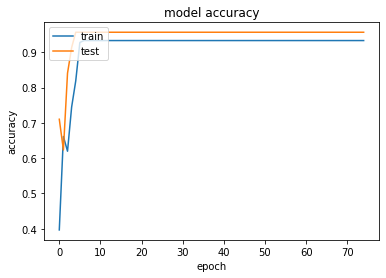

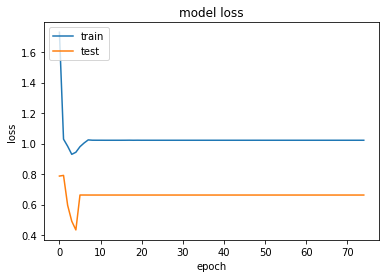

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=75, batch_size=256,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('best_model_embeddings.h5')


In [38]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait


# Create model from word input to output of dense layer right before the attention layer
# print( model.get_layer('time_distributed').output.shape,  len(model.get_layer('dense_final').get_weights()))
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('dense').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [39]:
for i in range(0,20):
    #print('data',data[i])
    in_data =data_temp[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    print('result:',y, in_data,train_df.iloc[i].toxicity_sentence)
    print('row:',len(train_df.iloc[i].sentence),train_df.iloc[i].sentence)
    hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
     # Compute context vector using output of dense layer
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    print('attention',(in_data, ait))

result: [[3.0116553]] [[  68  129    5  151    3    5  875   54   20   65   56 1908   85   10
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 70 because hes a moron and a bigot its not any more complicated than that
attention (array([[  68,  129,    5,  151,    3,    5,  875,   54,   20,   65,   56,
        1908,   85,   10,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   

attention (array([[  29, 1203,   10,  331,   33,   73, 1916,    2, 1917,   61,  331,
         233,   52,    0,   51,   24,   55,   27,   18,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]]), array([0.00885893, 0.00837026, 0.00905837, 0.01040228, 0.00962157,
       0.00966682, 0.01021327, 0.00917712, 0.01138192, 0.00895645,
       0.01038848, 0.009248  , 0.00880145, 0.00919491, 0.00877904,
       0.00922079, 0.00992121, 0.01005553, 0.01106211, 0.01229527,
       0.01223729, 0.01211793, 0.01197

attention (array([[ 418,    5,  332, 1206,   99,    2,  250,    2, 1207, 1922,   11,
         279, 1208,   53,    3, 1923,  131,  487,    4,    2, 1924,  882,
           3,  562,   68,    6,    8,   30,    2,   24,  673, 1209,   10,
         139, 1207,    5,  280,  281,    6,   24,  673, 1209,   11,  152,
           4,  333,    4,  563, 1925,  136,  102,  251,    6, 1926,   13,
          33,  674,   60,    2, 1210,    6,  883,    3, 1927,    0,   27,
         131,  168,  488, 1211,    9, 1928, 1929,   14,    5,   78,  884,
          15,   77,   99,  137,   26,  370,    4,   16, 1212,   60,  168,
           2, 1930,  217,   17,    8, 1213,   15,  310, 1931,  370,    9,
          22]]), array([0.00885399, 0.00925188, 0.00901149, 0.00855728, 0.00946344,
       0.00991878, 0.01076913, 0.01032058, 0.01079061, 0.01054563,
       0.00955247, 0.01005467, 0.01173389, 0.01066171, 0.00920115,
       0.01131653, 0.01131106, 0.01093795, 0.0097437 , 0.00934512,
       0.0086128 , 0.00870922, 0.00824

result: [[2.499625]] [[ 129    5 1967    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 16 hes a psychopath
attention (array([[ 129,    5, 1967,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

attention (array([[  13,  260,   52,  139,    2, 1985, 1986, 1987,    0,  339,    0,
           2,  896,    7,   43,  897, 1988,    3,  499,  169,    0,  898,
          52,    4,   80,   67,    0,    0,    0,    0,    0,    0,    0,
           0,  236,  899,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]]), array([0.00806072, 0.0083971 , 0.00875408, 0.0090856 , 0.00983842,
       0.0108289 , 0.01342085, 0.01269231, 0.01076051, 0.00975456,
       0.00913213, 0.00856181, 0.0087264 , 0.00885384, 0.0094571 ,
       0.00886698, 0.00963494, 0.00798142, 0.0097587 , 0.01106677,
       0.01118143, 0.01165328, 0.00981